# CNN para clasificación de imágenes con Pytorch

- Veremos cómo construir una CNN para clasificar imágenes en MNIST.

- También tocaremos un poco cómo trabajar con modelos preentrenados (Tranfer Learning) como el modelo de [ResNet](https://pytorch.org/vision/stable/models.html#resnet).

In [ ]:
# Importando líbrerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Barajar los indices
indices = np.arange(60000)
np.random.shuffle(indices)
n_train = 55000

# Transformar los datos en tensores y normalícelos
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Preparar el conjunto de entrenamiento y el conjunto de validación
dataset = datasets.MNIST('.', download=True, train=True, transform=transform)

# Construir el cargador de entranamiento
train_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[:n_train])
                            )

# Construir el cargador de validación
val_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[n_train:])
                            )

100%|██████████| 9912422/9912422 [00:00<00:00, 150263154.78it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 72061685.80it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37937910.51it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21285507.00it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
len(train_loader), len(val_loader)

(860, 79)

In [ ]:
dataset[0][0].shape, dataset[0][1]

(torch.Size([1, 28, 28]), 5)

In [ ]:
train_loader.batch_size, val_loader.batch_size

(64, 64)

In [ ]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true = []
        y_pred = []
        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true, y_pred)
        train_acc_history.append(train_acc)

        # set the model to evaluation mode
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                # Run the forward pass
                predicted_outputs = model(inputs)
                # Compute loss
                loss = criterion(predicted_outputs, labels)
                # Accumulate the average loss of the mini-batch
                val_loss += loss.item()
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs , 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # calculate the average validation loss and accuracy
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true, y_pred)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true)
        all_preds.extend(y_pred)

        print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds


def plotting_confusion_matrix(all_labels, all_preds, title_name=''):

    # Plotting Confusion Matrix
    fig, axs = plt.subplots(1, 2, figsize = (14, 6))

    # Implementing visualization of Confusion Matrix
    c_m = confusion_matrix(all_labels, all_preds)
    c_m_normalized = confusion_matrix(all_labels, all_preds, normalize='true').round(3)

    ConfusionMatrixDisplay(c_m, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[0])
    ConfusionMatrixDisplay(c_m_normalized*100, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[1],)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    axs[0].set_title('Valores absolutos', fontsize=14)
    axs[1].set_title('Valores porcentuales', fontsize=14)
    plt.suptitle(f'Confusion Matrix {title_name}', fontsize=16)
    plt.show()


def plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    fig, axs = plt.subplots(1, 2, figsize = (10, 4))

    # Plot the training and validation loss
    axs[0].plot(train_loss_history, label='train loss')
    axs[0].plot(val_loss_history, label='val loss')
    axs[0].grid()

    # Plot the training and validation accuracy
    axs[1].plot(train_acc_history, label='train acc')
    axs[1].plot(val_acc_history, label='val acc')
    axs[1].grid()
    plt.legend()
    plt.show()

## Modelo de clasificación con Capas Fully Connected

In [ ]:
# Define the class Net
class Net(nn.Module):
    def __init__(self, num_classes=10):
    	# Define all the parameters of the net
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 200)
        self.fc2 = nn.Linear(200, num_classes)

    def forward(self, x):
    	# Do the forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the Adam optimizer and Cross-Entropy loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(-1, 28 * 28)
    optimizer.zero_grad()
    # Complete a forward pass
    output = model(data)
    # Compute the loss, gradients and change the weights
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

# Set the model in eval mode
model.eval()
total, correct = (0, 0)
all_labels, all_preds = [], []
for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    all_labels.extend(list(labels.numpy()))

    # Put each image into a vector
    inputs = inputs.view(-1, 28*28*1)

    # Do the forward pass and get the predictions
    outputs = model(inputs)
    _, outputs = torch.max(outputs.data, 1)
    all_preds.extend(list(outputs.numpy()))
    total += labels.size(0)
    correct += (outputs == labels).sum().item()
print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))

The testing set accuracy of the network is: 94 %


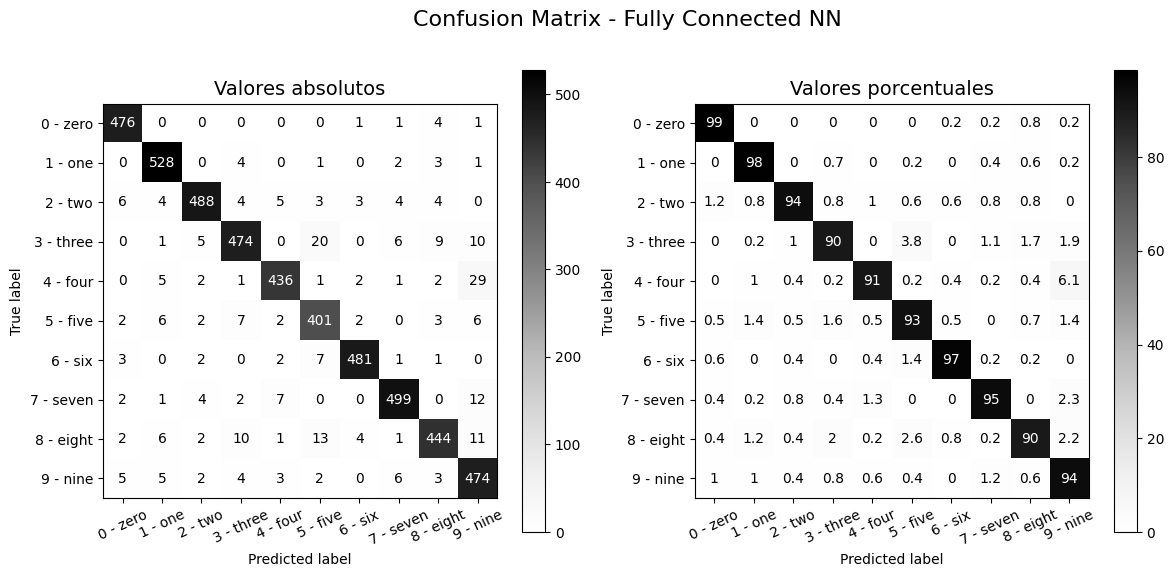

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- Fully Connected NN')

## Arquitecturas Bases

In [ ]:
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Instantiate a fully connected layer
        self.fc = nn.Linear(7 * 7 * 10, 10)


    def forward(self, x):
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, self.fc.in_features)
        # Apply the fully connected layer and return the result
        return self.fc(x)

In [ ]:
class NetwithoutPadding(nn.Module):
    def __init__(self):
        super(NetwithoutPadding, self).__init__()
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Instantiate a fully connected layer
        self.fc = nn.Linear(4 * 4 * 20, 10)


    def forward(self, x):
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, self.fc.in_features)
        # Apply the fully connected layer and return the result
        return self.fc(x)

## Entrenar Net without Padding

In [ ]:
num_epochs = 20
# Instantiate the network
model = NetwithoutPadding()
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Instantiate the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 0.1869, train acc: 0.9430, val loss: 0.0723, val acc: 0.9796
Epoch 2/20, train loss: 0.0590, train acc: 0.9812, val loss: 0.0703, val acc: 0.9792
Epoch 3/20, train loss: 0.0460, train acc: 0.9857, val loss: 0.0472, val acc: 0.9858
Epoch 4/20, train loss: 0.0387, train acc: 0.9880, val loss: 0.0459, val acc: 0.9846
Epoch 5/20, train loss: 0.0339, train acc: 0.9889, val loss: 0.0485, val acc: 0.9860
Epoch 6/20, train loss: 0.0302, train acc: 0.9906, val loss: 0.0420, val acc: 0.9878
Epoch 7/20, train loss: 0.0276, train acc: 0.9912, val loss: 0.0391, val acc: 0.9884
Epoch 8/20, train loss: 0.0264, train acc: 0.9919, val loss: 0.0375, val acc: 0.9888
Epoch 9/20, train loss: 0.0246, train acc: 0.9921, val loss: 0.0452, val acc: 0.9874
Epoch 10/20, train loss: 0.0228, train acc: 0.9935, val loss: 0.0454, val acc: 0.9870
Epoch 11/20, train loss: 0.0218, train acc: 0.9937, val loss: 0.0466, val acc: 0.9860
Epoch 12/20, train loss: 0.0207, train acc: 0.9941, val loss: 0

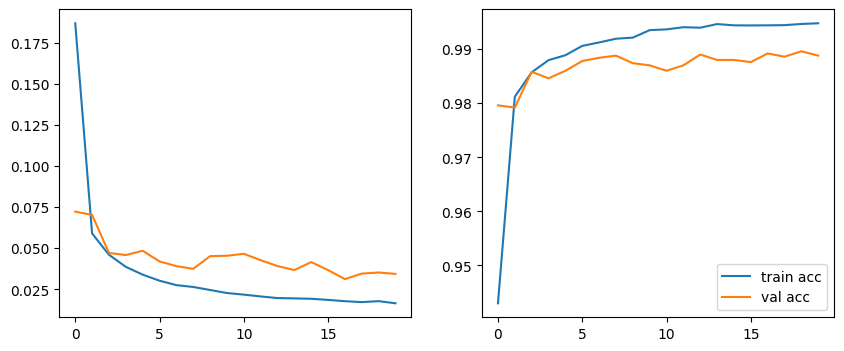

In [ ]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [ ]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([10, 1, 5, 5])
	conv1.bias: torch.Size([10])
	conv2.weight: torch.Size([20, 10, 5, 5])
	conv2.bias: torch.Size([20])
	fc.weight: torch.Size([10, 320])
	fc.bias: torch.Size([10])
Cantidad de parámetros:
	conv1.weight: 250
	conv1.bias: 10
	conv2.weight: 5000
	conv2.bias: 20
	fc.weight: 3200
	fc.bias: 10
Modelo: NetwithoutPadding(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)


## Entrenar NetCNN

In [ ]:
num_epochs = 20
model = NetCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 0.2190, train acc: 0.9306, val loss: 0.1098, val acc: 0.9664
Epoch 2/20, train loss: 0.0814, train acc: 0.9749, val loss: 0.0737, val acc: 0.9760
Epoch 3/20, train loss: 0.0646, train acc: 0.9796, val loss: 0.0701, val acc: 0.9766
Epoch 4/20, train loss: 0.0551, train acc: 0.9827, val loss: 0.0672, val acc: 0.9812
Epoch 5/20, train loss: 0.0503, train acc: 0.9845, val loss: 0.0600, val acc: 0.9822
Epoch 6/20, train loss: 0.0478, train acc: 0.9851, val loss: 0.0639, val acc: 0.9812
Epoch 7/20, train loss: 0.0440, train acc: 0.9859, val loss: 0.0575, val acc: 0.9814
Epoch 8/20, train loss: 0.0425, train acc: 0.9865, val loss: 0.0605, val acc: 0.9798
Epoch 9/20, train loss: 0.0407, train acc: 0.9871, val loss: 0.0544, val acc: 0.9820
Epoch 10/20, train loss: 0.0401, train acc: 0.9872, val loss: 0.0596, val acc: 0.9808
Epoch 11/20, train loss: 0.0377, train acc: 0.9877, val loss: 0.0607, val acc: 0.9804
Epoch 12/20, train loss: 0.0374, train acc: 0.9882, val loss: 0

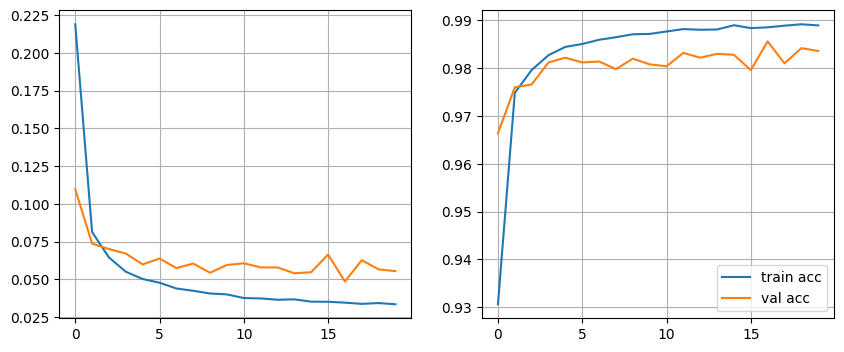

In [ ]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [ ]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([5, 1, 3, 3])
	conv1.bias: torch.Size([5])
	conv2.weight: torch.Size([10, 5, 3, 3])
	conv2.bias: torch.Size([10])
	fc.weight: torch.Size([10, 490])
	fc.bias: torch.Size([10])
Cantidad de parámetros:
	conv1.weight: 45
	conv1.bias: 5
	conv2.weight: 450
	conv2.bias: 10
	fc.weight: 4900
	fc.bias: 10
Modelo: NetCNN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=490, out_features=10, bias=True)
)


## Modificar el modelo

In [ ]:
# Change the number of out channels
model.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=0)
model.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0)
model.fc = nn.Linear(5 * 5 * 8, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 0.2430, train acc: 0.9243, val loss: 0.1181, val acc: 0.9650
Epoch 2/20, train loss: 0.0970, train acc: 0.9701, val loss: 0.0893, val acc: 0.9738
Epoch 3/20, train loss: 0.0834, train acc: 0.9747, val loss: 0.0840, val acc: 0.9744
Epoch 4/20, train loss: 0.0755, train acc: 0.9772, val loss: 0.0793, val acc: 0.9762
Epoch 5/20, train loss: 0.0718, train acc: 0.9781, val loss: 0.0815, val acc: 0.9748
Epoch 6/20, train loss: 0.0676, train acc: 0.9798, val loss: 0.0760, val acc: 0.9776
Epoch 7/20, train loss: 0.0631, train acc: 0.9802, val loss: 0.0912, val acc: 0.9738
Epoch 8/20, train loss: 0.0626, train acc: 0.9804, val loss: 0.0730, val acc: 0.9788
Epoch 9/20, train loss: 0.0581, train acc: 0.9822, val loss: 0.0741, val acc: 0.9790
Epoch 10/20, train loss: 0.0583, train acc: 0.9821, val loss: 0.0706, val acc: 0.9796
Epoch 11/20, train loss: 0.0570, train acc: 0.9823, val loss: 0.0674, val acc: 0.9788
Epoch 12/20, train loss: 0.0549, train acc: 0.9829, val loss: 0

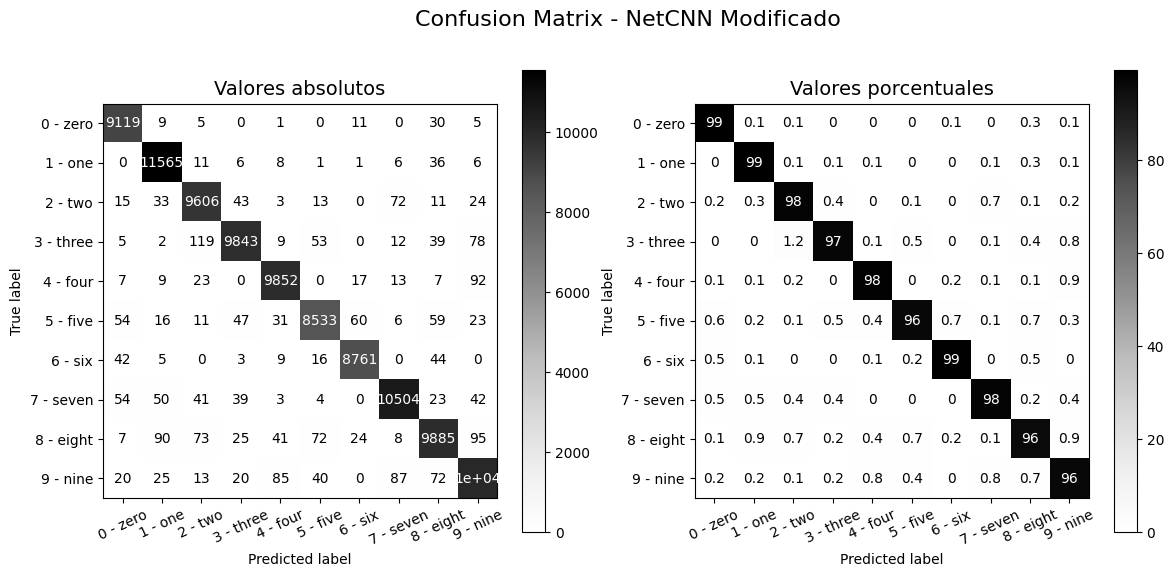

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- NetCNN Modificado')

In [ ]:
# Otra manera de cambiar los parámetros de la red
setattr(model, 'conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=0))
setattr(model, 'conv2', nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0))
setattr(model, 'fc', nn.Linear(5 * 5 * 8, 10))
print(f'Modelo: {model}')

Modelo: NetCNN(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)


## Ejemplo de Otra Arquitectura con Batch Normalization

In [ ]:
# Model with batch normalization
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()

        # Implement the sequential module for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(20))

        # Implement the fully connected layer for classification
        self.fc = nn.Linear(in_features=4 * 4 * 20, out_features=10)

    def forward(self, x):

        # Apply the feature extractor in the input
        x = self.features(x)

        # Squeeze the three spatial dimensions in one
        x = x.view(-1, self.fc.in_features)

        # Classify the images
        x = self.fc(x)
        return x

In [ ]:
# Entrenamiento con optimizador Adam
num_epochs = 20
model = NetBN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.001)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 0.1036, train acc: 0.9679, val loss: 0.0807, val acc: 0.9722
Epoch 2/20, train loss: 0.0649, train acc: 0.9799, val loss: 0.0764, val acc: 0.9762
Epoch 3/20, train loss: 0.0647, train acc: 0.9800, val loss: 0.0817, val acc: 0.9764
Epoch 4/20, train loss: 0.0642, train acc: 0.9799, val loss: 0.1051, val acc: 0.9670
Epoch 5/20, train loss: 0.0662, train acc: 0.9793, val loss: 0.0644, val acc: 0.9810
Epoch 6/20, train loss: 0.0639, train acc: 0.9797, val loss: 0.0667, val acc: 0.9792
Epoch 7/20, train loss: 0.0658, train acc: 0.9793, val loss: 0.0667, val acc: 0.9790
Epoch 8/20, train loss: 0.0623, train acc: 0.9805, val loss: 0.0929, val acc: 0.9736
Epoch 9/20, train loss: 0.0628, train acc: 0.9806, val loss: 0.0684, val acc: 0.9808
Epoch 10/20, train loss: 0.0627, train acc: 0.9802, val loss: 0.0833, val acc: 0.9776
Epoch 11/20, train loss: 0.0638, train acc: 0.9798, val loss: 0.0642, val acc: 0.9778
Epoch 12/20, train loss: 0.0634, train acc: 0.9797, val loss: 0

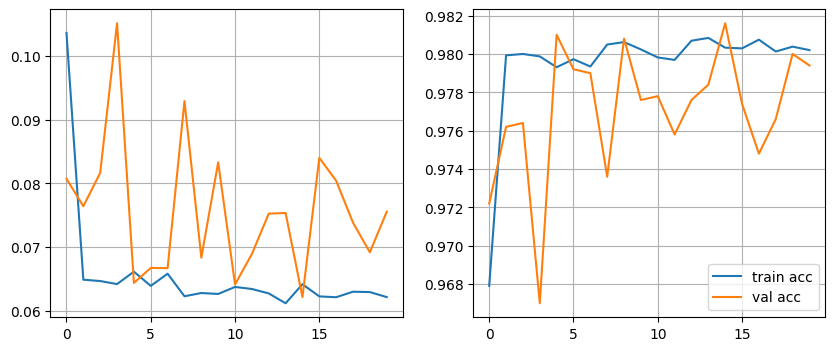

In [ ]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [ ]:
# Entrenamiento con optimizador SGD con momentum
num_epochs = 20
model = NetBN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 0.1171, train acc: 0.9656, val loss: 0.0600, val acc: 0.9842
Epoch 2/20, train loss: 0.0465, train acc: 0.9865, val loss: 0.0508, val acc: 0.9842
Epoch 3/20, train loss: 0.0369, train acc: 0.9893, val loss: 0.0415, val acc: 0.9876
Epoch 4/20, train loss: 0.0315, train acc: 0.9909, val loss: 0.0427, val acc: 0.9882
Epoch 5/20, train loss: 0.0278, train acc: 0.9925, val loss: 0.0365, val acc: 0.9896
Epoch 6/20, train loss: 0.0249, train acc: 0.9932, val loss: 0.0393, val acc: 0.9892
Epoch 7/20, train loss: 0.0234, train acc: 0.9934, val loss: 0.0344, val acc: 0.9906
Epoch 8/20, train loss: 0.0217, train acc: 0.9943, val loss: 0.0359, val acc: 0.9892
Epoch 9/20, train loss: 0.0206, train acc: 0.9947, val loss: 0.0380, val acc: 0.9872
Epoch 10/20, train loss: 0.0195, train acc: 0.9947, val loss: 0.0368, val acc: 0.9888
Epoch 11/20, train loss: 0.0189, train acc: 0.9954, val loss: 0.0378, val acc: 0.9894
Epoch 12/20, train loss: 0.0173, train acc: 0.9957, val loss: 0

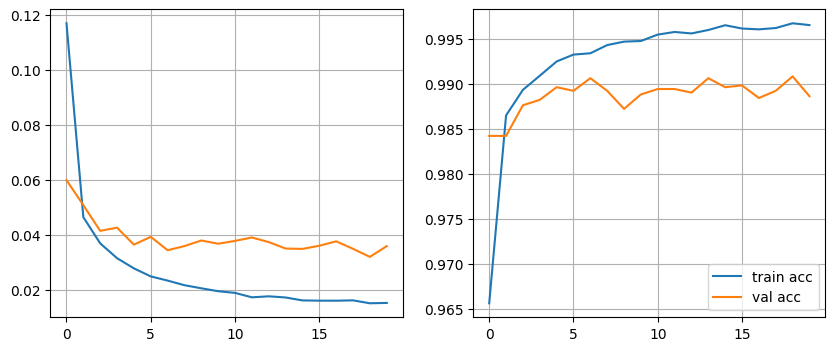

In [ ]:
plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

**¿Aplicar batch normalization antes o después de la función de activación?**

Se sugiere:
- Con función de activación ReLU --> aplicar antes
- Con función de activación sigmoides (tanh y logística) --> aplicar después

En general, funciona mejor aplicar batch normalization antes de la función de activación.

Sin embargo, siempre es bueno probar ambos ordenes para ver qué funciona mejor.

In [ ]:
# Probar aplicar batch normalization antes de la activación ReLU (Concluir)




## Transfer Learning

In [ ]:
# Barajar los indices
indices = np.arange(50000)
np.random.shuffle(indices)
n_train = 45000

# Transformar los datos en tensores y normalícelos
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.261))])  # cifar-10
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])  # imagenet
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Preparar el conjunto de entrenamiento y el conjunto de validación
dataset = datasets.CIFAR10('.', download=False, train=True, transform=transform)

# Construir el cargador de entranamiento
train_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[:n_train])
                            )

# Construir el cargador de validación
val_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[n_train:])
                            )

In [ ]:
# Cargar el modelo preentrenado
model_rn18 = torchvision.models.resnet18()
print(f'Modelo: {model_rn18}')

Modelo: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [ ]:
# Explorar las capas del modelo
for i, w in enumerate(model_rn18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [ ]:
# Una muestra de lo que hace anteponer un * a una lista
lista_demo = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
print(lista_demo, end='\n\n')
print(*lista_demo)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']

conv1 bn1 relu maxpool layer1 layer2 layer3 layer4 avgpool fc


In [ ]:
# Seleccionar las capas que no se van a entrenar
# model_fit_rn18 = nn.Sequential(*list(model_rn18.children()))  # Selecciona todas las capas
model_fit_rn18 = nn.Sequential(*list(model_rn18.children())[:-1])  # Selecciona todas las capas excepto la última
model_fit_rn18

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Congelar todas las capas excepto la última, para que no se entrenen
for param in model_fit_rn18.parameters():
    param.requires_grad = False

# Agregar la capa de salida ajustada a nuestra salida y entrenar
model_fitted_resnet18 = nn.Sequential(
                            model_fit_rn18,
                            nn.Flatten(),   # aplana la salida obtenida de la capa anterior
                            nn.Linear(in_features=512, out_features=10, bias=True))  # el valor 512 es el número de canales de la última capa convolucional

In [ ]:
# Explorar las capas del modelo
for i, w in enumerate(model_fitted_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) False
1 torch.Size([64]) False
2 torch.Size([64]) False
3 torch.Size([64, 64, 3, 3]) False
4 torch.Size([64]) False
5 torch.Size([64]) False
6 torch.Size([64, 64, 3, 3]) False
7 torch.Size([64]) False
8 torch.Size([64]) False
9 torch.Size([64, 64, 3, 3]) False
10 torch.Size([64]) False
11 torch.Size([64]) False
12 torch.Size([64, 64, 3, 3]) False
13 torch.Size([64]) False
14 torch.Size([64]) False
15 torch.Size([128, 64, 3, 3]) False
16 torch.Size([128]) False
17 torch.Size([128]) False
18 torch.Size([128, 128, 3, 3]) False
19 torch.Size([128]) False
20 torch.Size([128]) False
21 torch.Size([128, 64, 1, 1]) False
22 torch.Size([128]) False
23 torch.Size([128]) False
24 torch.Size([128, 128, 3, 3]) False
25 torch.Size([128]) False
26 torch.Size([128]) False
27 torch.Size([128, 128, 3, 3]) False
28 torch.Size([128]) False
29 torch.Size([128]) False
30 torch.Size([256, 128, 3, 3]) False
31 torch.Size([256]) False
32 torch.Size([256]) False
33 torch.Size([256, 2

In [ ]:
# Entrenar la última capa del modelo
num_epochs = 10
model_tl = model_fitted_resnet18
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tl.parameters(), lr=5e-4, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-2, weight_decay=0.001)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model_tl, criterion, optimizer, train_loader, val_loader, num_epochs)


Epoch 1/10, train loss: 2.0886, train acc: 0.2458, val loss: 1.9644, val acc: 0.3020
Epoch 2/10, train loss: 1.9514, train acc: 0.3048, val loss: 1.9280, val acc: 0.3044
Epoch 3/10, train loss: 1.9205, train acc: 0.3182, val loss: 1.8957, val acc: 0.3274
Epoch 4/10, train loss: 1.9062, train acc: 0.3214, val loss: 1.9223, val acc: 0.3184
Epoch 5/10, train loss: 1.8988, train acc: 0.3268, val loss: 1.9031, val acc: 0.3198
Epoch 6/10, train loss: 1.8936, train acc: 0.3274, val loss: 1.9056, val acc: 0.3322
Epoch 7/10, train loss: 1.8928, train acc: 0.3278, val loss: 1.9046, val acc: 0.3212
Epoch 8/10, train loss: 1.8908, train acc: 0.3270, val loss: 1.9016, val acc: 0.3230
Epoch 9/10, train loss: 1.8900, train acc: 0.3265, val loss: 1.9177, val acc: 0.3154
Epoch 10/10, train loss: 1.8860, train acc: 0.3303, val loss: 1.9007, val acc: 0.3208


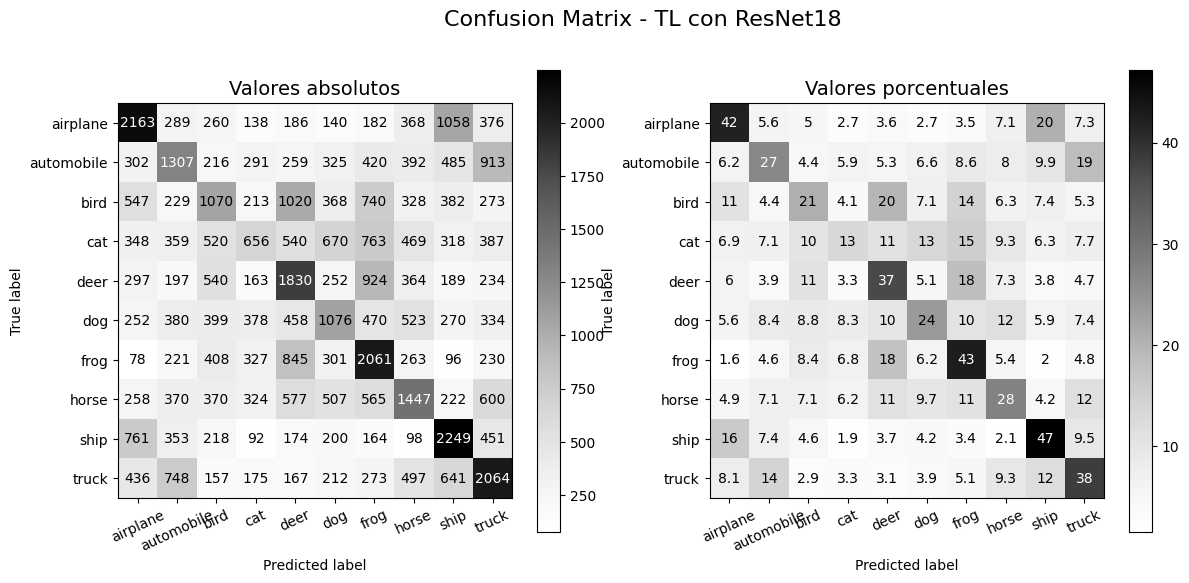

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- TL con ResNet18')


In [ ]:
# Entrenar la última capa del modelo
num_epochs = 100
model_tl = model_fitted_resnet18
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-4, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-2, weight_decay=0.001)
train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model_tl, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/100, train loss: 2.1924, train acc: 0.1896, val loss: 2.1269, val acc: 0.2256
Epoch 2/100, train loss: 2.0892, train acc: 0.2474, val loss: 2.0619, val acc: 0.2490
Epoch 3/100, train loss: 2.0354, train acc: 0.2704, val loss: 2.0190, val acc: 0.2748
Epoch 4/100, train loss: 1.9995, train acc: 0.2842, val loss: 1.9974, val acc: 0.2804
Epoch 5/100, train loss: 1.9684, train acc: 0.2986, val loss: 1.9623, val acc: 0.2970
Epoch 6/100, train loss: 1.9477, train acc: 0.3059, val loss: 1.9441, val acc: 0.3046
Epoch 7/100, train loss: 1.9290, train acc: 0.3114, val loss: 1.9259, val acc: 0.3046
Epoch 8/100, train loss: 1.9146, train acc: 0.3167, val loss: 1.9204, val acc: 0.3252
Epoch 9/100, train loss: 1.8990, train acc: 0.3227, val loss: 1.9062, val acc: 0.3222
Epoch 10/100, train loss: 1.8878, train acc: 0.3265, val loss: 1.8921, val acc: 0.3194
Epoch 11/100, train loss: 1.8779, train acc: 0.3274, val loss: 1.8847, val acc: 0.3254
Epoch 12/100, train loss: 1.8691, train acc: 0.3352,

### Otro modelo p/transfer learning

In [ ]:
# Probar otro modelo
model_fit_vgg16 = torchvision.models.vgg16()
model_fit_vgg16
# model_fit_vgg19 = nn.Sequential(*list(model_fit_vgg19.children())[:-1])  # Seleccionar todas las capas excepto la última

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Veamos el grupos de capas clasificadoras
model_fit_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# Veamos la última capa clasificadora
model_fit_vgg16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model_tl = model_fit_vgg16
# Modifiquemos algunas capas clasificadoras para reentrenarla con los datos y poder hacer la clasificación de 10 clases
for param in model_tl.parameters():
    param.requires_grad = False

n_clases = 10
model_tl.classifier[3].requires_grad = True
model_tl.classifier[3] = nn.Linear(4096, 2048)
model_tl.classifier[6].requires_grad = True
model_tl.classifier[6] = nn.Linear(2048, n_clases)
model_tl.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
# Explorar las capas del modelo
for i, w in enumerate(model_tl.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) False
1 torch.Size([64]) False
2 torch.Size([64, 64, 3, 3]) False
3 torch.Size([64]) False
4 torch.Size([128, 64, 3, 3]) False
5 torch.Size([128]) False
6 torch.Size([128, 128, 3, 3]) False
7 torch.Size([128]) False
8 torch.Size([256, 128, 3, 3]) False
9 torch.Size([256]) False
10 torch.Size([256, 256, 3, 3]) False
11 torch.Size([256]) False
12 torch.Size([256, 256, 3, 3]) False
13 torch.Size([256]) False
14 torch.Size([512, 256, 3, 3]) False
15 torch.Size([512]) False
16 torch.Size([512, 512, 3, 3]) False
17 torch.Size([512]) False
18 torch.Size([512, 512, 3, 3]) False
19 torch.Size([512]) False
20 torch.Size([512, 512, 3, 3]) False
21 torch.Size([512]) False
22 torch.Size([512, 512, 3, 3]) False
23 torch.Size([512]) False
24 torch.Size([512, 512, 3, 3]) False
25 torch.Size([512]) False
26 torch.Size([4096, 25088]) False
27 torch.Size([4096]) False
28 torch.Size([2048, 4096]) True
29 torch.Size([2048]) True
30 torch.Size([10, 2048]) True
31 torch.Size([10])

In [ ]:
# Barajar los indices
indices = np.arange(50000)
np.random.shuffle(indices)
n_train = 45000

# Transformar los datos en tensores y normalícelos
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize (height x width)
    transforms.ToTensor(),
    # Media y desviación estándar de imagenes image-net
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Preparar el conjunto de entrenamiento y el conjunto de validación
dataset = datasets.CIFAR10('.', download=True, train=True, transform=transform)

# Construir el cargador de entranamiento
train_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[:n_train])
                            )

# Construir el cargador de validación
val_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[n_train:])
)

100%|██████████| 170498071/170498071 [00:05<00:00, 30501763.61it/s]


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-4, betas=(0.9, 0.999))

train_loss_history, train_acc_history, val_loss_history, val_acc_history, all_labels, all_preds = train_val(model_tl, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/10, train loss: 2.1245, train acc: 0.2325, val loss: 1.9521, val acc: 0.3104
Epoch 2/10, train loss: 1.9213, train acc: 0.3113, val loss: 1.8402, val acc: 0.3420
Epoch 3/10, train loss: 1.8504, train acc: 0.3390, val loss: 1.7828, val acc: 0.3694
Epoch 4/10, train loss: 1.8046, train acc: 0.3548, val loss: 1.7239, val acc: 0.3954
Epoch 5/10, train loss: 1.7690, train acc: 0.3683, val loss: 1.6930, val acc: 0.4006
Epoch 6/10, train loss: 1.7428, train acc: 0.3791, val loss: 1.6561, val acc: 0.4180
Epoch 7/10, train loss: 1.7215, train acc: 0.3857, val loss: 1.6371, val acc: 0.4222
Epoch 8/10, train loss: 1.7081, train acc: 0.3897, val loss: 1.6202, val acc: 0.4340
Epoch 9/10, train loss: 1.6944, train acc: 0.3934, val loss: 1.6007, val acc: 0.4328
Epoch 10/10, train loss: 1.6839, train acc: 0.3992, val loss: 1.5869, val acc: 0.4390


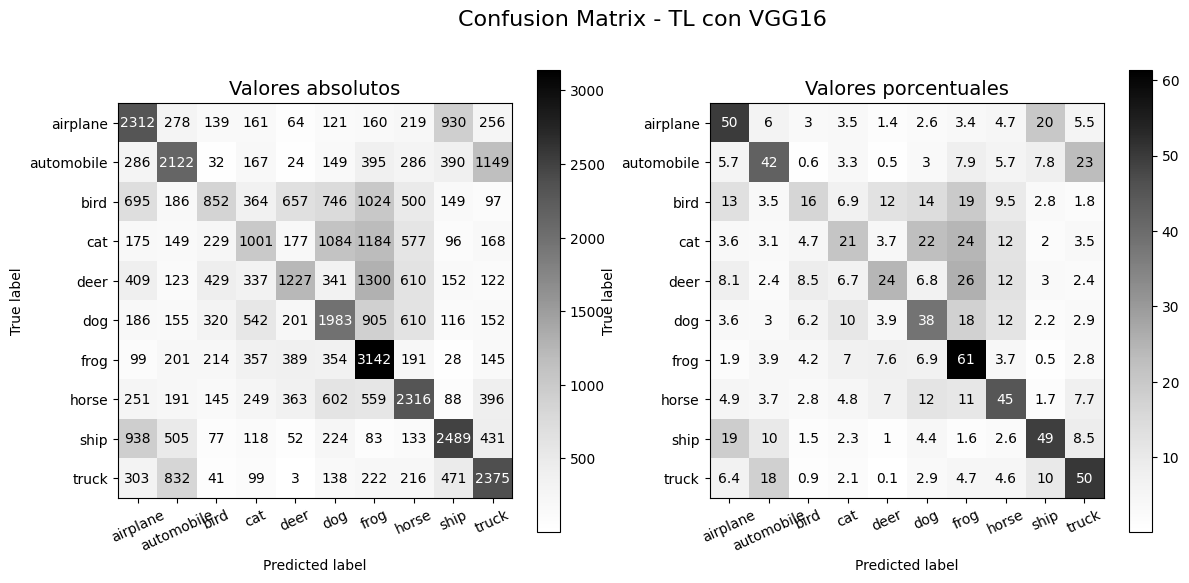

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- TL con VGG16')

### Para jugar con el modelo

In [ ]:
# Modifique este grupo de capas de clasificación para reentrenar el modelo con nuestros datos
# Reentrenar la segunda capa lineal
model_tl.classifier[3].requires_grad = True
# Modificar la última y penúltima capa de clasificación para reducir el número de parámetros
model_tl.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(256, n_clases))

In [ ]:
model_tl.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)